# Preliminary data exploration for the Lending Club data set

This workbook is for me to familiarize myself with the data we have

In [2]:
# standard headers copied from HW 4
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline

In [3]:
# Andrew's additional top-level setup
plt.style.use('ggplot')  # looks better and is more informative
from collections import namedtuple  # makes returning complex values less error-prone

In [7]:
# Read in the raw data taken from TODO put url here
raw_lc_data = pd.read_csv('data/loan.csv',
                         )

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


TODO: We got the following warning:

```C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
```

so we'll have to pay particular attention to columns 19 and 55.

In [8]:
for date_column in [
    'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line'
]:
    print date_column
    raw_lc_data[date_column] = pd.to_datetime(raw_lc_data[date_column],
                                              format='%b-%Y')

issue_d
last_pymnt_d
next_pymnt_d
last_credit_pull_d
earliest_cr_line


In [9]:
print raw_lc_data.columns

Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
       u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
       u'emp_title', u'emp_length', u'home_ownership', u'annual_inc',
       u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan',
       u'url', u'desc', u'purpose', u'title', u'zip_code', u'addr_state',
       u'dti', u'delinq_2yrs', u'earliest_cr_line', u'inq_last_6mths',
       u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc',
       u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d',
       u'last_credit_pull_d', u'collections_12_mths_ex_med',
       u'mths_since_last_major_derog', u'policy_code', u'application_type',
       u'annu

In [38]:
# Let's create a helper function that will explore each column
def explore_column(data, c):
    print '---------------------------'
    col_data = data[c]
    nulls = pd.isnull(col_data)
    col_data = col_data[~nulls]
    if col_data.dtype == '<M8[ns]':
        col_data = col_data.dt.strftime('%Y-%m')
    defaults = data['loan_status'] == 'Charged Off'  # for now TODO
    
    # Does it have a small number of values?
    vcounts = col_data.value_counts()
    vcounts_default = col_data[defaults].value_counts()[vcounts.index]
    
    print "%s: dtype=%s, %d nulls, count vals=%d" % (
        c, col_data.dtype, sum(nulls), len(vcounts)
    )
    # Is it categorical?
    if len(vcounts) < 20 or col_data.dtype == 'O':
        print "Total number of distinct values: %d" % (len(vcounts), )

        if len(vcounts) > 20:
            # Reduce it to a reasonable number.
            vcounts = vcounts[0:19].append(pd.Series(vcounts[19:].sum(), index=['Others']))
            vcounts_default = vcounts_default[0:19].append(pd.Series(vcounts_default[19:].sum(), index=['Others']))

        print "Total counts"
        print vcounts
        print "Counts for defaulting loans"
        print vcounts_default
        plt.title(c)
        plt.bar(range(len(vcounts)), vcounts, color='b')
        plt.bar(range(len(vcounts)), vcounts_default, color='r')
        plt.gca().set_xticks(np.arange(0.5, 0.5+len(vcounts)))
        plt.gca().set_xticklabels(vcounts.index)
        plt.show()
        return

    try:
        # It must be numeric at this point
        # We want to see Quartiles, 95% interval, min/max
        quantiles_good = col_data[~defaults].quantile(q=[0, 0.025, 0.25, 0.50, 0.75, 0.975, 1.0]).tolist()
        quantiles_defaults = col_data[defaults].quantile(q=[0, 0.025, 0.25, 0.50, 0.75, 0.975, 1.0]).tolist()
        print "     %10s  %10s  %10s  %10s  %10s  %10s  %10s" % (
            'Min', '2.5%', '25%', '50%', '75%', '97.5%', 'Max',
        )
        print "GOOD %10.2f  %10.2f  %10.2f  %10.2f  %10.2f  %10.2f  %10.2f" % tuple(quantiles_good)
        print "BAD  %10.2f  %10.2f  %10.2f  %10.2f  %10.2f  %10.2f  %10.2f" % tuple(quantiles_defaults)

        fig, axs = plt.subplots(2, 1, sharex=True)

        plt.axes(axs[0])
        plt.title(c + " - Good")
        plt.hist(col_data[~defaults], bins=40, color='b')
        plt.axvline(x=col_data[~defaults].mean(), color='k')
        plt.xlim(col_data.min(), col_data.max())
        for q in quantiles_good:
            plt.axvline(x=q, color='b')

        plt.axes(axs[1])
        plt.title(c + " - Bad")
        plt.hist(col_data[defaults], bins=40, color='r')
        plt.axvline(x=col_data[defaults].mean(), color='k')
        plt.xlim(col_data.min(), col_data.max())
        for q in quantiles_defaults:
            plt.axvline(x=q, color='r')

        plt.show()
    except Exception as e:
        print e

## Unit test the exploration function

---------------------------
grade: dtype=object, 0 nulls, count vals=7
Total number of distinct values: 7
Total counts
B    254535
C    245860
A    148202
D    139542
E     70705
F     23046
G      5489
Name: grade, dtype: int64
Counts for defaulting loans
B     9519
C    12642
A     2617
D    10486
E     6258
F     2934
G      792
Name: grade, dtype: int64


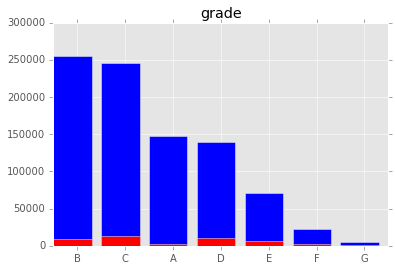

In [26]:
explore_column(raw_lc_data, 'grade')

---------------------------
sub_grade: dtype=object, 0 nulls, count vals=35
Total number of distinct values: 35
Total counts
B3         56323
B4         55626
C1         53387
C2         52236
C3         50161
C4         48857
B5         48833
B2         48781
B1         44972
A5         44816
C5         41219
D1         36238
A4         34531
D2         29803
D3         26554
D4         25558
A3         23457
A1         22913
A2         22485
Others    120629
dtype: int64
Counts for defaulting loans
B3         2259
B4         2323
C1         2483
C2         2531
C3         2551
C4         2564
B5         2131
B2         1593
B1         1213
A5          981
C5         2513
D1         2368
A4          779
D2         2270
D3         2040
D4         2085
A3          399
A1          181
A2          277
Others    11707
dtype: int64


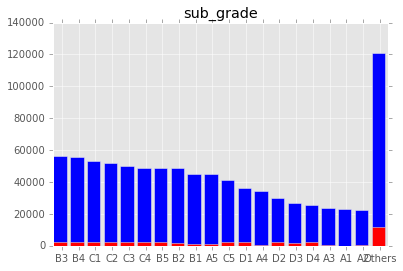

In [27]:
explore_column(raw_lc_data, 'sub_grade')

---------------------------
mths_since_last_record: dtype=float64, 750326 nulls, count vals=123
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       12.00       51.00       69.00       91.00      117.00      121.00
BAD        0.00        8.00       58.00       86.00      103.00      117.00      129.00


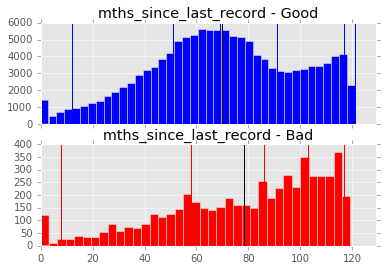

In [39]:
explore_column(raw_lc_data, 'mths_since_last_record')

## Explore the data
Now that we have tested our exploration function, let's iterate over all the columns

---------------------------
id: dtype=int64, 0 nulls, count vals=887379
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD   54734.00   681317.75  10424727.50  36723207.00  55351977.00  66632422.75  68617057.00
BAD    57167.00   500326.15  1568881.75  6581844.00  15021673.00  42505257.97  60516983.00


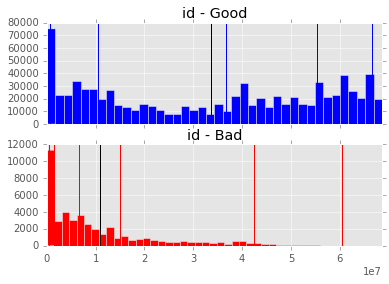

---------------------------
member_id: dtype=int64, 0 nulls, count vals=887379
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD   70473.00   868605.50  12022788.50  39424080.00  58953287.00  71358193.25  73544841.00
BAD    80353.00   641491.88  1824480.25  8047168.00  16742592.75  45472061.12  64537751.00


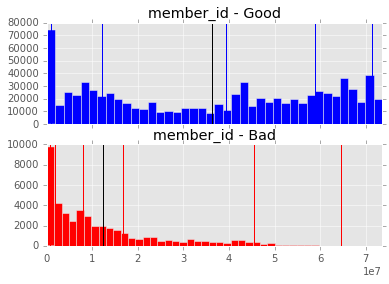

---------------------------
loan_amnt: dtype=float64, 0 nulls, count vals=1372
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD     500.00     2500.00     8000.00    13000.00    20000.00    35000.00    35000.00
BAD      900.00     2500.00     8000.00    12675.00    20000.00    35000.00    35000.00


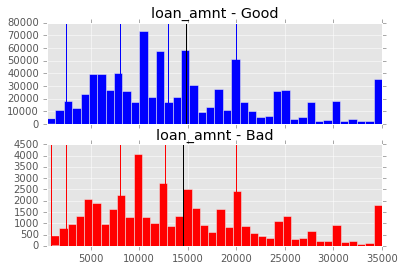

---------------------------
funded_amnt: dtype=float64, 0 nulls, count vals=1372
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD     500.00     2500.00     8000.00    13000.00    20000.00    35000.00    35000.00
BAD      900.00     2500.00     8000.00    12600.00    20000.00    35000.00    35000.00


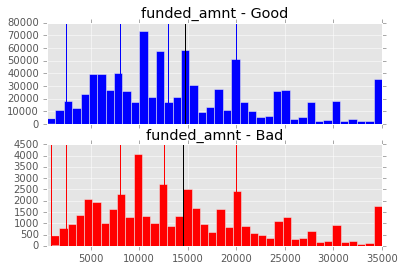

---------------------------
funded_amnt_inv: dtype=float64, 0 nulls, count vals=9856
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     2500.00     8000.00    13000.00    20000.00    35000.00    35000.00
BAD        0.00     2400.00     8000.00    12375.00    19975.00    35000.00    35000.00


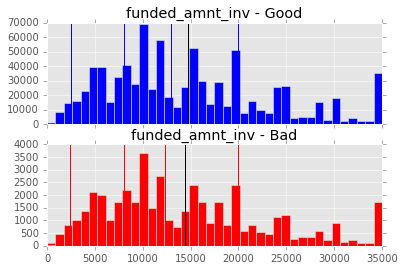

---------------------------
term: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
Total counts
 36 months    621125
 60 months    266254
Name: term, dtype: int64
Counts for defaulting loans
 36 months    29083
 60 months    16165
Name: term, dtype: int64


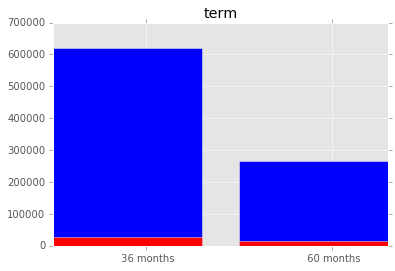

---------------------------
int_rate: dtype=float64, 0 nulls, count vals=542
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       5.32        6.03        9.99       12.87       15.80       22.99       28.99
BAD        5.42        7.88       13.05       15.80       18.92       24.83       28.99


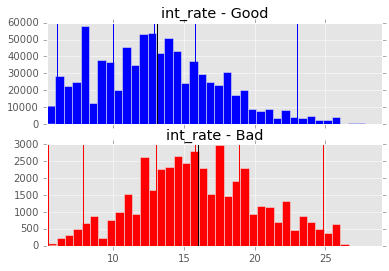

---------------------------
installment: dtype=float64, 0 nulls, count vals=68711
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD      15.67       87.42      260.55      382.55      572.58     1050.98     1445.46
BAD       21.62       85.62      265.18      390.83      573.32     1033.01     1424.57


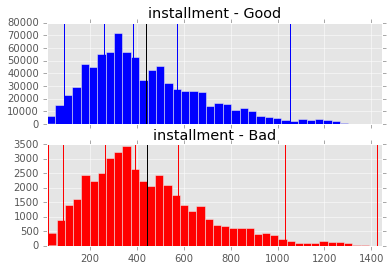

---------------------------
grade: dtype=object, 0 nulls, count vals=7
Total number of distinct values: 7
Total counts
B    254535
C    245860
A    148202
D    139542
E     70705
F     23046
G      5489
Name: grade, dtype: int64
Counts for defaulting loans
B     9519
C    12642
A     2617
D    10486
E     6258
F     2934
G      792
Name: grade, dtype: int64


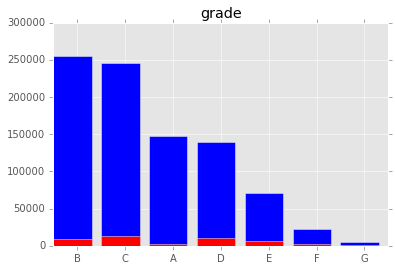

---------------------------
sub_grade: dtype=object, 0 nulls, count vals=35
Total number of distinct values: 35
Total counts
B3         56323
B4         55626
C1         53387
C2         52236
C3         50161
C4         48857
B5         48833
B2         48781
B1         44972
A5         44816
C5         41219
D1         36238
A4         34531
D2         29803
D3         26554
D4         25558
A3         23457
A1         22913
A2         22485
Others    120629
dtype: int64
Counts for defaulting loans
B3         2259
B4         2323
C1         2483
C2         2531
C3         2551
C4         2564
B5         2131
B2         1593
B1         1213
A5          981
C5         2513
D1         2368
A4          779
D2         2270
D3         2040
D4         2085
A3          399
A1          181
A2          277
Others    11707
dtype: int64


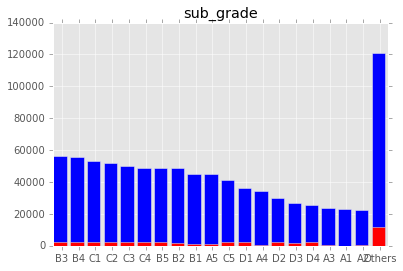

---------------------------
emp_title: dtype=object, 51457 nulls, count vals=299272
Total number of distinct values: 299272
Total counts
Teacher              13469
Manager              11240
Registered Nurse      5525
Owner                 5376
RN                    5355
Supervisor            4983
Sales                 4212
Project Manager       3988
Driver                3569
Office Manager        3510
General Manager       3178
Director              3156
manager               3138
teacher               2925
owner                 2849
Engineer              2671
President             2598
driver                2429
Vice President        2351
Others              749400
dtype: int64
Counts for defaulting loans
Teacher               315.0
Manager               381.0
Registered Nurse      152.0
Owner                 111.0
RN                    143.0
Supervisor            166.0
Sales                 139.0
Project Manager        87.0
Driver                140.0
Office Manager         80.0
Ge

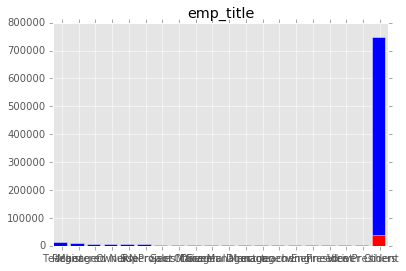

---------------------------
emp_length: dtype=object, 0 nulls, count vals=12
Total number of distinct values: 12
Total counts
10+ years    291569
2 years       78870
< 1 year      70605
3 years       70026
1 year        57095
5 years       55704
4 years       52529
n/a           44825
7 years       44594
8 years       43955
6 years       42950
9 years       34657
Name: emp_length, dtype: int64
Counts for defaulting loans
10+ years    13133
2 years       4033
< 1 year      3853
3 years       3534
1 year        2964
5 years       3203
4 years       2775
n/a           2525
7 years       2602
8 years       2154
6 years       2695
9 years       1777
Name: emp_length, dtype: int64


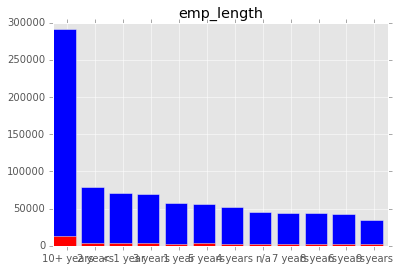

---------------------------
home_ownership: dtype=object, 0 nulls, count vals=6
Total number of distinct values: 6
Total counts
MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          182
NONE            50
ANY              3
Name: home_ownership, dtype: int64
Counts for defaulting loans
MORTGAGE    19878.0
RENT        21311.0
OWN          4025.0
OTHER          27.0
NONE            7.0
ANY             NaN
Name: home_ownership, dtype: float64


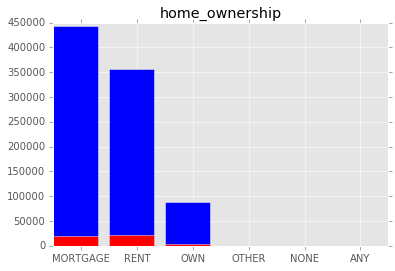

---------------------------
annual_inc: dtype=float64, 4 nulls, count vals=49384
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00    24000.00    45900.00    65000.00    90000.00   190000.00  9500000.00
BAD     4080.00    21180.70    40000.00    56000.00    78000.00   160000.00  8706582.00


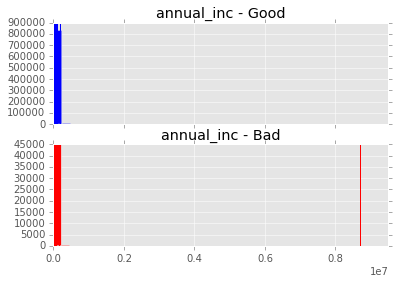

---------------------------
verification_status: dtype=object, 0 nulls, count vals=3
Total number of distinct values: 3
Total counts
Source Verified    329558
Verified           291071
Not Verified       266750
Name: verification_status, dtype: int64
Counts for defaulting loans
Source Verified    13740
Verified           19300
Not Verified       12208
Name: verification_status, dtype: int64


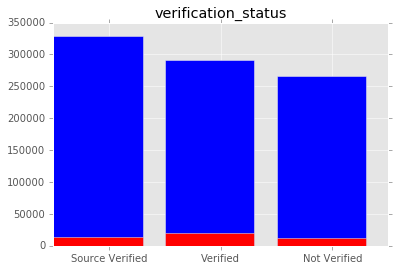

---------------------------
issue_d: dtype=object, 0 nulls, count vals=103
Total number of distinct values: 103
Total counts
2015-10     48631
2015-07     45962
2015-12     44342
2014-10     38782
2015-11     37530
2015-08     35886
2015-04     35427
2015-01     35107
2015-05     31913
2014-07     29306
2015-09     28641
2015-06     28485
2015-03     25400
2014-11     25054
2015-02     23770
2014-05     19099
2014-04     19071
2014-08     18814
2014-06     17179
Others     298980
dtype: int64
Counts for defaulting loans
2015-10        NaN
2015-07       93.0
2015-12        NaN
2014-10     1722.0
2015-11        NaN
2015-08       25.0
2015-04      428.0
2015-01      911.0
2015-05      243.0
2014-07     1754.0
2015-09        5.0
2015-06      126.0
2015-03      436.0
2014-11      861.0
2015-02      506.0
2014-05     1343.0
2014-04     1436.0
2014-08     1068.0
2014-06     1133.0
Others     33158.0
dtype: float64


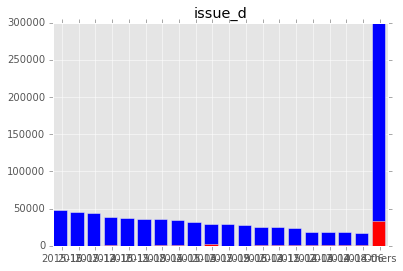

---------------------------
loan_status: dtype=object, 0 nulls, count vals=10
Total number of distinct values: 10
Total counts
Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64
Counts for defaulting loans
Current                                                    NaN
Fully Paid                                                 NaN
Charged Off                                            45248.0
Late

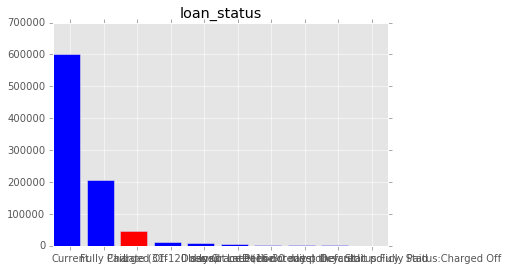

---------------------------
pymnt_plan: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
Total counts
n    887369
y        10
Name: pymnt_plan, dtype: int64
Counts for defaulting loans
n    45248.0
y        NaN
Name: pymnt_plan, dtype: float64


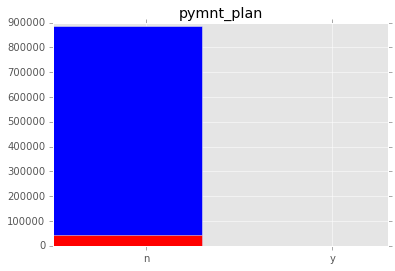

---------------------------
url: dtype=object, 0 nulls, count vals=887379
Total number of distinct values: 887379
Total counts
https://www.lendingclub.com/browse/loanDetail.action?loan_id=39370264         1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=58912224         1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=11235664         1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=44096304         1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=12425441         1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=657563           1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=15291174         1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=49943332         1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=2594900          1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=49943330         1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=62854634    

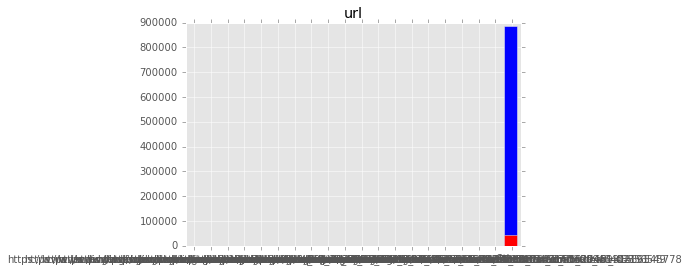

---------------------------
desc: dtype=object, 761350 nulls, count vals=124470
Total number of distinct values: 124470
Total counts
                                                            246
Debt Consolidation                                           13
  Borrower added on 03/17/14 > Debt consolidation<br>        11
  Borrower added on 03/10/14 > Debt consolidation<br>        10
  Borrower added on 02/19/14 > Debt consolidation<br>         9
  Borrower added on 01/29/14 > Debt consolidation<br>         8
Camping Membership                                            8
  Borrower added on 01/15/14 > Debt consolidation<br>         7
  Borrower added on 01/22/14 > Debt consolidation<br>         7
  Borrower added on 02/03/14 > Debt consolidation<br>         6
  Borrower added on 03/07/14 > Debt consolidation<br>         6
  Borrower added on 01/27/14 > Debt consolidation<br>         6
  Borrower added on 01/14/13 > Debt consolidation<br>         6
  Borrower added on 03/03/14 > Debt

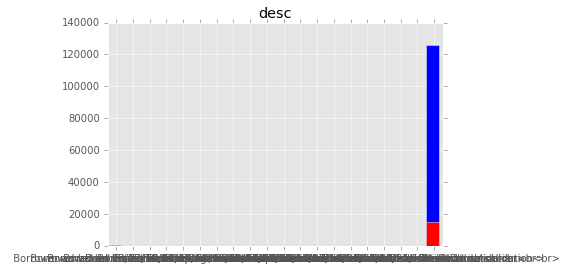

---------------------------
purpose: dtype=object, 0 nulls, count vals=14
Total number of distinct values: 14
Total counts
debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64
Counts for defaulting loans
debt_consolidation    27599
credit_card            7826
home_improvement       2269
other                  2936
major_purchase          874
small_business         1371
car                     448
medical                 569
moving                  425
vacation                270
house                   286
wedding                 265
renewable_energy         54
educational              56
Name: purpose, dtype: i

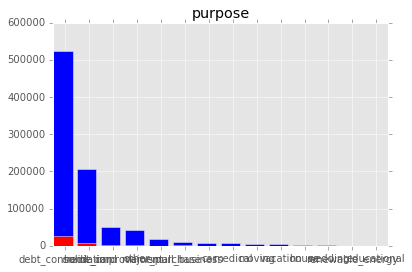

---------------------------
title: dtype=object, 151 nulls, count vals=63145
Total number of distinct values: 63145
Total counts
Debt consolidation           414001
Credit card refinancing      164331
Home improvement              40112
Other                         31892
Debt Consolidation            15760
Major purchase                12051
Business                       6728
Medical expenses               6674
Car financing                  5565
Consolidation                  5381
debt consolidation             4834
Moving and relocation          3921
Vacation                       3805
Debt Consolidation Loan        3804
Home buying                    2365
Credit Card Consolidation      2359
consolidation                  2174
Personal Loan                  2133
Consolidation Loan             1778
Others                       157560
dtype: int64
Counts for defaulting loans
Debt consolidation           13477.0
Credit card refinancing       3715.0
Home improvement              1061.0

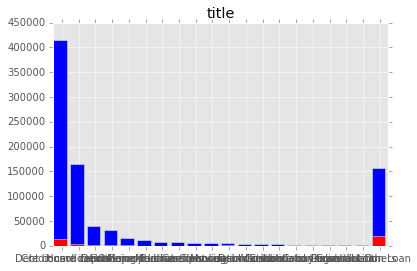

---------------------------
zip_code: dtype=object, 0 nulls, count vals=935
Total number of distinct values: 935
Total counts
945xx       9770
750xx       9417
112xx       9272
606xx       8641
300xx       8126
100xx       7609
070xx       7431
331xx       7416
900xx       7287
770xx       6938
891xx       6441
917xx       6357
330xx       6283
117xx       6129
104xx       6008
921xx       5661
852xx       5442
926xx       5415
913xx       5160
Others    752576
dtype: int64
Counts for defaulting loans
945xx       502.0
750xx       434.0
112xx       551.0
606xx       352.0
300xx       360.0
100xx       357.0
070xx       406.0
331xx       491.0
900xx       420.0
770xx       297.0
891xx       457.0
917xx       402.0
330xx       388.0
117xx       322.0
104xx       371.0
921xx       345.0
852xx       268.0
926xx       323.0
913xx       289.0
Others    37913.0
dtype: float64


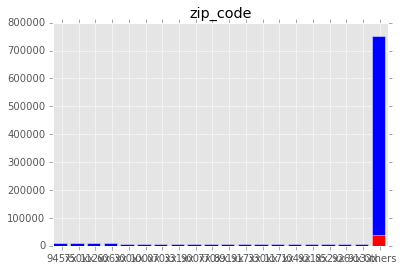

---------------------------
addr_state: dtype=object, 0 nulls, count vals=51
Total number of distinct values: 51
Total counts
CA        129517
NY         74086
TX         71138
FL         60935
IL         35476
NJ         33256
PA         31393
OH         29631
GA         29085
VA         26255
NC         24720
MI         22985
MD         21031
MA         20593
AZ         20412
WA         19434
CO         18807
MN         15957
MO         14207
Others    188461
dtype: int64
Counts for defaulting loans
CA        7332.0
NY        4124.0
TX        3035.0
FL        3524.0
IL        1542.0
NJ        1841.0
PA        1557.0
OH        1472.0
GA        1360.0
VA        1438.0
NC        1306.0
MI        1150.0
MD        1100.0
MA        1017.0
AZ        1049.0
WA         986.0
CO         784.0
MN         803.0
MO         781.0
Others    9047.0
dtype: float64


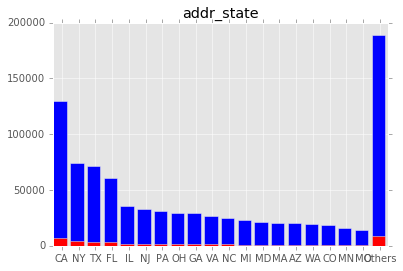

---------------------------
dti: dtype=float64, 0 nulls, count vals=4086
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        3.54       11.88       17.62       23.94       34.89     9999.00
BAD        0.00        3.49       12.57       18.35       24.09       33.64       39.98


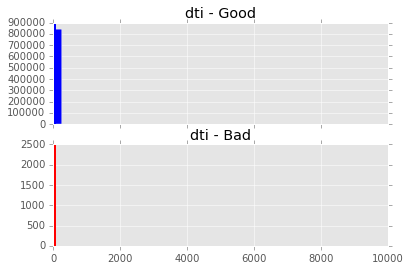

---------------------------
delinq_2yrs: dtype=float64, 29 nulls, count vals=29
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        3.00       39.00
BAD        0.00        0.00        0.00        0.00        0.00        2.00       18.00


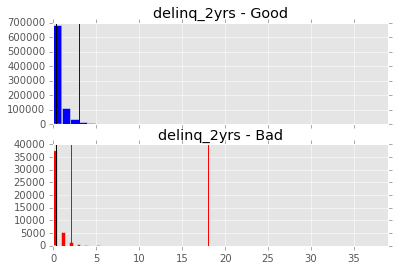

---------------------------
earliest_cr_line: dtype=object, 29 nulls, count vals=697
Total number of distinct values: 697
Total counts
2001-08      6659
2000-08      6529
2000-10      6322
2001-10      6154
2002-08      6086
2000-09      5918
1999-11      5878
1999-10      5824
2000-11      5822
2002-09      5812
2002-10      5684
2001-09      5678
2003-09      5612
1999-08      5598
1999-09      5588
2001-07      5330
2001-11      5223
2003-10      5212
2003-08      5205
Others     777216
dtype: int64
Counts for defaulting loans
2001-08      312.0
2000-08      352.0
2000-10      365.0
2001-10      318.0
2002-08      260.0
2000-09      291.0
1999-11      324.0
1999-10      292.0
2000-11      335.0
2002-09      283.0
2002-10      287.0
2001-09      274.0
2003-09      257.0
1999-08      317.0
1999-09      304.0
2001-07      289.0
2001-11      323.0
2003-10      275.0
2003-08      234.0
Others     39556.0
dtype: float64


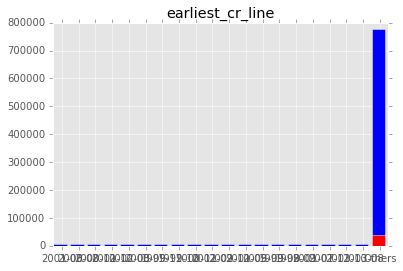

---------------------------
inq_last_6mths: dtype=float64, 29 nulls, count vals=28
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        1.00        3.00       33.00
BAD        0.00        0.00        0.00        1.00        2.00        4.00        8.00


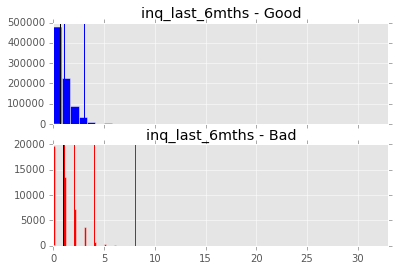

---------------------------
mths_since_last_delinq: dtype=float64, 454312 nulls, count vals=155
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        3.00       15.00       31.00       50.00       78.00      188.00
BAD        0.00        3.00       15.00       31.00       50.00       78.00      152.00


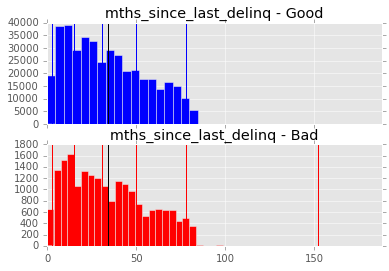

---------------------------
mths_since_last_record: dtype=float64, 750326 nulls, count vals=123
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       12.00       51.00       69.00       91.00      117.00      121.00
BAD        0.00        8.00       58.00       86.00      103.00      117.00      129.00


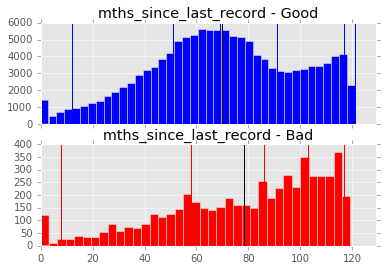

---------------------------
open_acc: dtype=float64, 29 nulls, count vals=77
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        4.00        8.00       11.00       14.00       24.00       90.00
BAD        0.00        4.00        8.00       10.00       14.00       23.00       76.00


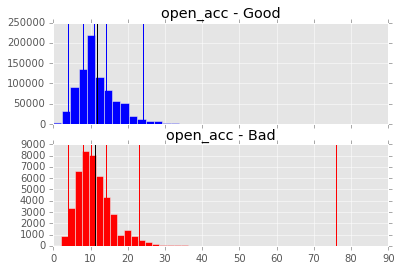

---------------------------
pub_rec: dtype=float64, 29 nulls, count vals=32
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        2.00       86.00
BAD        0.00        0.00        0.00        0.00        0.00        1.00       12.00


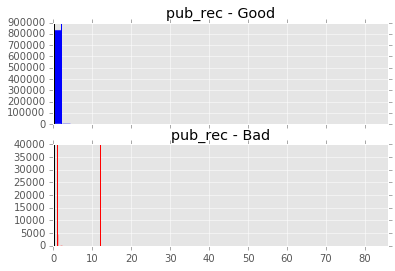

---------------------------
revol_bal: dtype=float64, 0 nulls, count vals=73740
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     1098.00     6456.00    11906.00    20928.00    58937.75  2904836.00
BAD        0.00      770.00     6226.75    11351.50    19204.00    47578.12  1746716.00


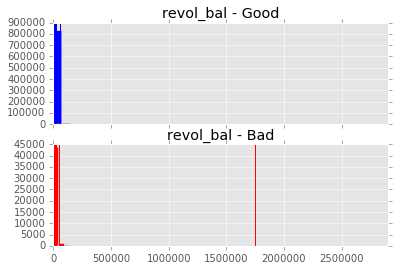

---------------------------
revol_util: dtype=float64, 502 nulls, count vals=1356
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        7.60       37.40       55.70       73.30       95.90      892.30
BAD        0.00        8.50       43.30       61.60       78.00       96.50      129.40


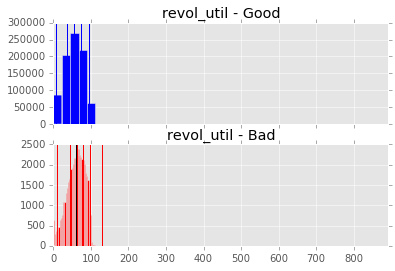

---------------------------
total_acc: dtype=float64, 29 nulls, count vals=135
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       1.00        7.00       17.00       24.00       32.00       53.00      169.00
BAD        2.00        7.00       16.00       23.00       31.00       51.00      110.00


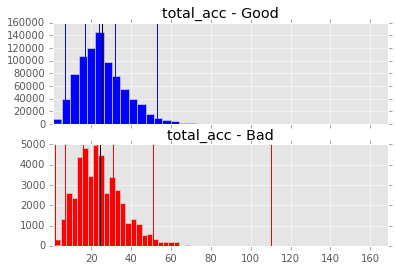

---------------------------
initial_list_status: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
Total counts
f    456848
w    430531
Name: initial_list_status, dtype: int64
Counts for defaulting loans
f    32933
w    12315
Name: initial_list_status, dtype: int64


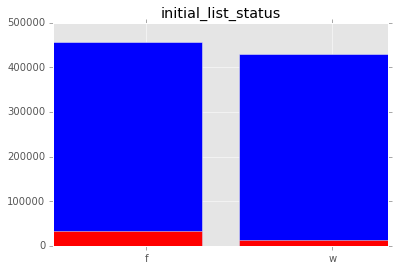

---------------------------
out_prncp: dtype=float64, 0 nulls, count vals=248332
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00     7148.83    14086.27    29329.49    49372.86
BAD        0.00        0.00        0.00        0.00        0.00        0.00        0.00


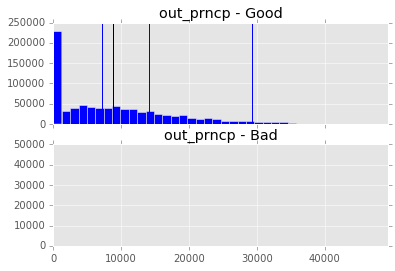

---------------------------
out_prncp_inv: dtype=float64, 0 nulls, count vals=266244
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00     7147.54    14078.69    29319.52    49372.86
BAD        0.00        0.00        0.00        0.00        0.00        0.00        0.00


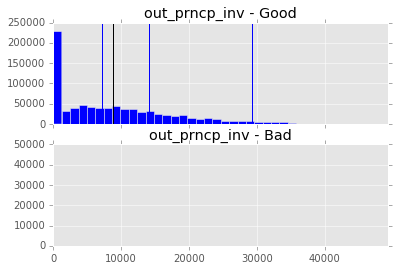

---------------------------
total_pymnt: dtype=float64, 0 nulls, count vals=506726
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00      133.04     1879.68     4896.71    10760.04    29930.50    57777.58
BAD        0.00      459.07     2502.76     4873.24     8624.95    20765.46    46199.44


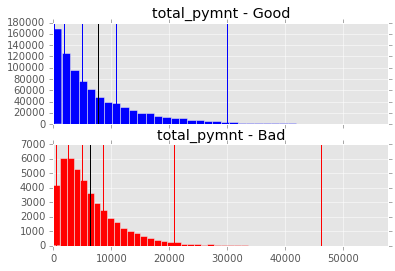

---------------------------
total_pymnt_inv: dtype=float64, 0 nulls, count vals=506616
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00      128.39     1869.45     4865.62    10703.24    29831.89    57777.58
BAD        0.00      419.42     2460.31     4809.99     8545.52    20643.98    46162.55


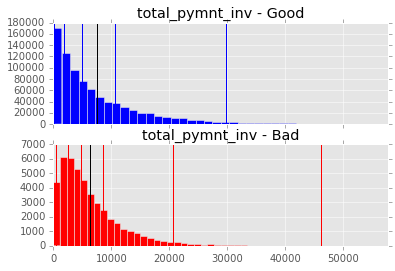

---------------------------
total_rec_prncp: dtype=float64, 0 nulls, count vals=260227
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       93.26     1207.56     3300.00     8048.23    25000.00    35000.03
BAD        0.00      144.23     1103.17     2319.40     4448.95    12154.24    34483.27


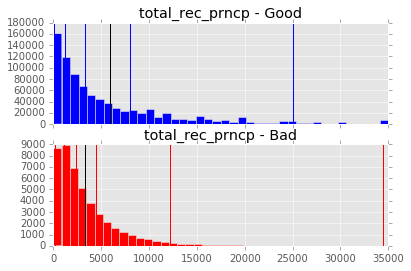

---------------------------
total_rec_int: dtype=float64, 0 nulls, count vals=324635
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       24.74      430.98     1054.26     2208.41     7741.50    24205.62
BAD        0.00       92.25      683.55     1430.36     2770.92     8451.62    20610.17


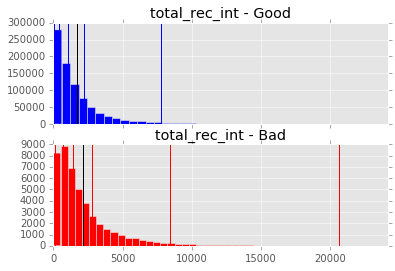

---------------------------
total_rec_late_fee: dtype=float64, 0 nulls, count vals=6181
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        0.00      286.75
BAD        0.00        0.00        0.00        0.00        0.00       30.93      358.68


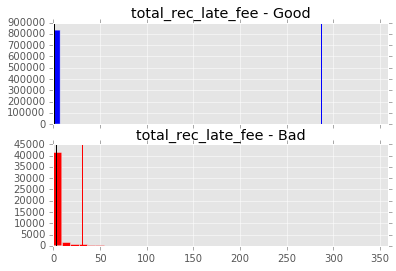

---------------------------
recoveries: dtype=float64, 0 nulls, count vals=23055
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        0.00    27750.00
BAD        0.00        0.00        0.00       35.06     1259.55     4800.17    33520.27


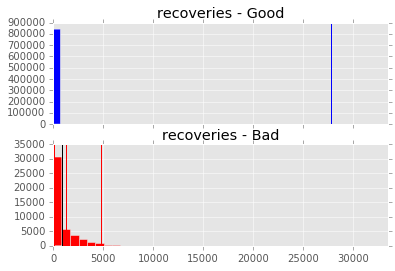

---------------------------
collection_recovery_fee: dtype=float64, 0 nulls, count vals=20708
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00        0.00     5192.99
BAD        0.00        0.00        0.00        1.07       26.64      809.76     7002.19


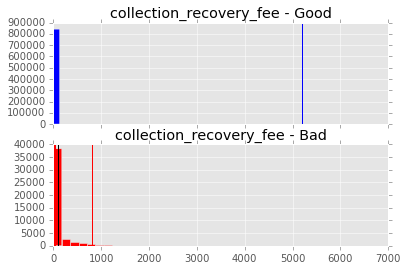

---------------------------
last_pymnt_d: dtype=object, 17659 nulls, count vals=98
Total number of distinct values: 98
Total counts
2016-01    470150
2015-12    150861
2015-10     16000
2015-07     14483
2015-11     13981
2015-09     13834
2015-08     13040
2015-06     11983
2015-04     11107
2015-05     11069
2015-03     10760
2015-02      8849
2015-01      8658
2014-10      7676
2014-12      7253
2014-09      6316
2014-07      6312
2014-08      6305
2014-11      6206
Others      74877
dtype: int64
Counts for defaulting loans
2016-01       23.0
2015-12      115.0
2015-10      321.0
2015-07     3137.0
2015-11      122.0
2015-09      650.0
2015-08     1948.0
2015-06     2622.0
2015-04     2195.0
2015-05     2365.0
2015-03     2142.0
2015-02     1646.0
2015-01     1688.0
2014-10     1748.0
2014-12     1681.0
2014-09     1550.0
2014-07     1374.0
2014-08     1451.0
2014-11     1387.0
Others     16556.0
dtype: float64


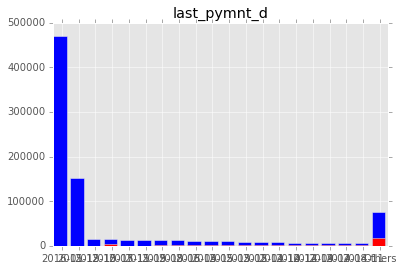

---------------------------
last_pymnt_amnt: dtype=float64, 0 nulls, count vals=232451
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       32.95      282.55      468.80      859.48    18417.85    36475.59
BAD        0.00       30.21      235.83      374.99      568.55     1177.42    34833.35


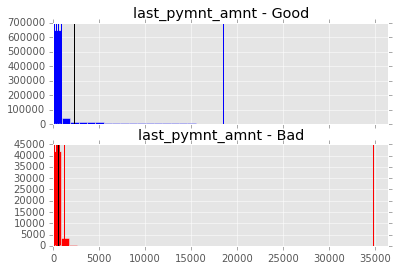

---------------------------
next_pymnt_d: dtype=object, 252971 nulls, count vals=100
Total number of distinct values: 100
Total counts
2016-02    553406
2016-01     78195
2011-03       107
2011-04       101
2011-02        91
2011-01        79
2011-05        77
2010-12        71
2016-03        68
2011-06        66
2011-09        63
2011-08        57
2010-11        55
2010-08        54
2011-07        53
2009-10        53
2009-12        53
2010-09        53
2009-11        52
Others       1654
dtype: int64
Counts for defaulting loans
2016-02   NaN
2016-01   NaN
2011-03   NaN
2011-04   NaN
2011-02   NaN
2011-01   NaN
2011-05   NaN
2010-12   NaN
2016-03   NaN
2011-06   NaN
2011-09   NaN
2011-08   NaN
2010-11   NaN
2010-08   NaN
2011-07   NaN
2009-10   NaN
2009-12   NaN
2010-09   NaN
2009-11   NaN
Others    NaN
dtype: float64


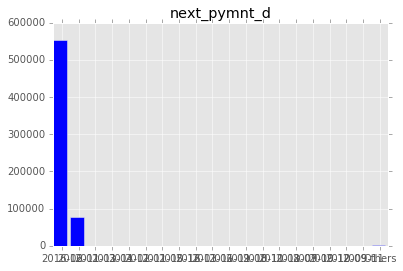

---------------------------
last_credit_pull_d: dtype=object, 53 nulls, count vals=103
Total number of distinct values: 103
Total counts
2016-01    730574
2015-12     19308
2015-11     11490
2015-10     10419
2015-09     10087
2015-07      8642
2015-08      7987
2015-06      7130
2015-04      6160
2015-05      5930
2015-03      5775
2015-01      5271
2015-02      5017
2014-12      3702
2014-10      3358
2014-11      3168
2014-09      2961
2014-08      2812
2014-07      2773
Others      34762
dtype: int64
Counts for defaulting loans
2016-01    19891.0
2015-12     3712.0
2015-11       63.0
2015-10       70.0
2015-09     1049.0
2015-07     1152.0
2015-08     1089.0
2015-06     1023.0
2015-04      944.0
2015-05      895.0
2015-03     1166.0
2015-01     1129.0
2015-02     1029.0
2014-12      941.0
2014-10      701.0
2014-11      788.0
2014-09      622.0
2014-08      605.0
2014-07      559.0
Others      7814.0
dtype: float64


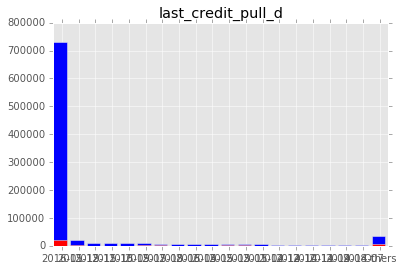

---------------------------
collections_12_mths_ex_med: dtype=float64, 145 nulls, count vals=12
Total number of distinct values: 12
Total counts
0.0     875553
1.0      10824
2.0        732
3.0         88
4.0         23
5.0          7
6.0          2
20.0         1
16.0         1
14.0         1
10.0         1
7.0          1
Name: collections_12_mths_ex_med, dtype: int64
Counts for defaulting loans
0.0     44897.0
1.0       327.0
2.0        17.0
3.0         NaN
4.0         1.0
5.0         NaN
6.0         NaN
20.0        NaN
16.0        NaN
14.0        NaN
10.0        NaN
7.0         NaN
Name: collections_12_mths_ex_med, dtype: float64


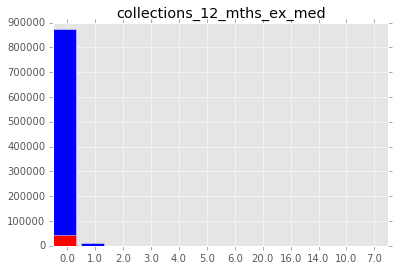

---------------------------
mths_since_last_major_derog: dtype=float64, 665676 nulls, count vals=168
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        6.00       27.00       44.00       61.00       81.00      188.00
BAD        0.00        6.00       25.00       42.00       60.00       80.00      152.00


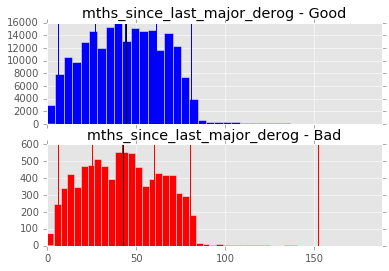

---------------------------
policy_code: dtype=float64, 0 nulls, count vals=1
Total number of distinct values: 1
Total counts
1.0    887379
Name: policy_code, dtype: int64
Counts for defaulting loans
1.0    45248
Name: policy_code, dtype: int64


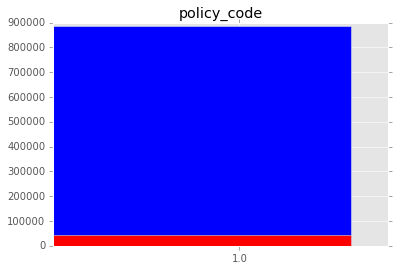

---------------------------
application_type: dtype=object, 0 nulls, count vals=2
Total number of distinct values: 2
Total counts
INDIVIDUAL    886868
JOINT            511
Name: application_type, dtype: int64
Counts for defaulting loans
INDIVIDUAL    45248.0
JOINT             NaN
Name: application_type, dtype: float64


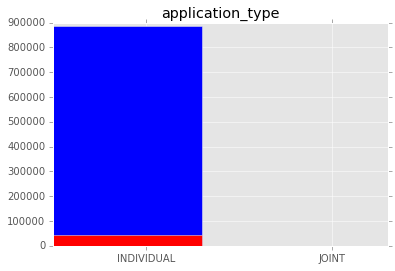

---------------------------
annual_inc_joint: dtype=float64, 886868 nulls, count vals=308
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD   17950.00    40866.00    76032.50   101771.00   132800.00   216500.00   500000.00
BAD         nan         nan         nan         nan         nan         nan         nan


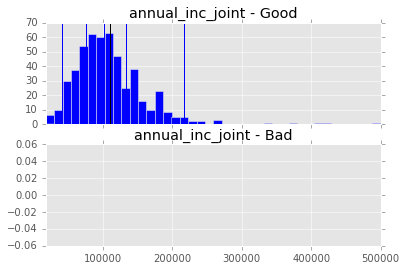

---------------------------
dti_joint: dtype=float64, 886870 nulls, count vals=449
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       3.00        6.29       13.20       17.61       22.65       33.11       43.86
BAD         nan         nan         nan         nan         nan         nan         nan


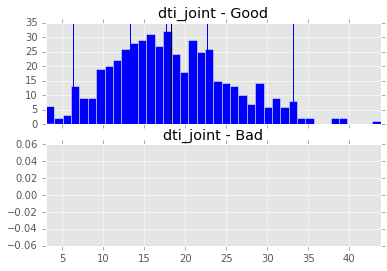

---------------------------
verification_status_joint: dtype=object, 886868 nulls, count vals=3
Total number of distinct values: 3
Total counts
Not Verified       283
Verified           167
Source Verified     61
Name: verification_status_joint, dtype: int64
Counts for defaulting loans
Not Verified      NaN
Verified          NaN
Source Verified   NaN
Name: verification_status_joint, dtype: float64


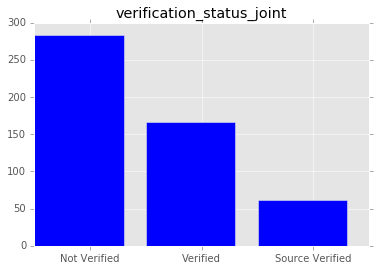

---------------------------
acc_now_delinq: dtype=float64, 29 nulls, count vals=8
Total number of distinct values: 8
Total counts
0.0     883236
1.0       3866
2.0        208
3.0         28
4.0          7
5.0          3
14.0         1
6.0          1
Name: acc_now_delinq, dtype: int64
Counts for defaulting loans
0.0     45088.0
1.0       148.0
2.0         9.0
3.0         2.0
4.0         NaN
5.0         1.0
14.0        NaN
6.0         NaN
Name: acc_now_delinq, dtype: float64


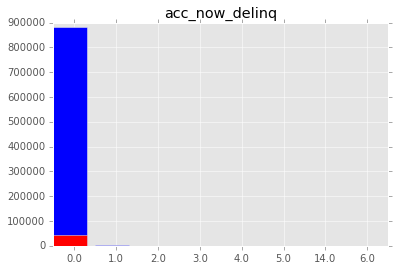

---------------------------
tot_coll_amt: dtype=float64, 70276 nulls, count vals=10325
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        0.00     1638.00  9152545.00
BAD        0.00        0.00        0.00        0.00        0.00      972.00    95806.00


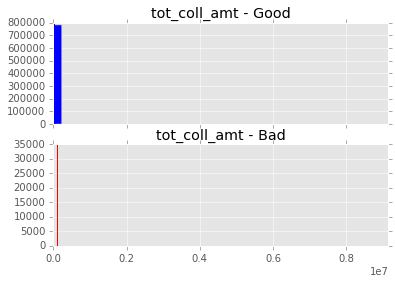

---------------------------
tot_cur_bal: dtype=float64, 70276 nulls, count vals=327342
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     6011.00    30076.00    81655.50   209923.75   521151.52  8000078.00
BAD        0.00     5878.70    25670.00    59738.00   172573.00   434454.90  3437283.00


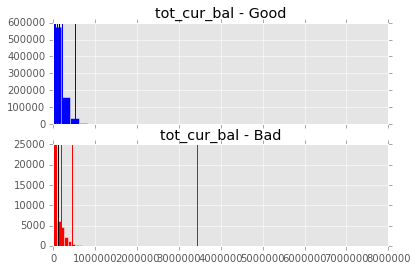

---------------------------
open_acc_6m: dtype=float64, 866007 nulls, count vals=13
Total number of distinct values: 13
Total counts
0.0     8246
1.0     6808
2.0     3752
3.0     1572
4.0      593
5.0      232
6.0      104
7.0       37
8.0       13
9.0        7
10.0       4
14.0       2
12.0       2
Name: open_acc_6m, dtype: int64
Counts for defaulting loans
0.0    NaN
1.0    NaN
2.0    NaN
3.0    NaN
4.0    NaN
5.0    NaN
6.0    NaN
7.0    NaN
8.0    NaN
9.0    NaN
10.0   NaN
14.0   NaN
12.0   NaN
Name: open_acc_6m, dtype: float64


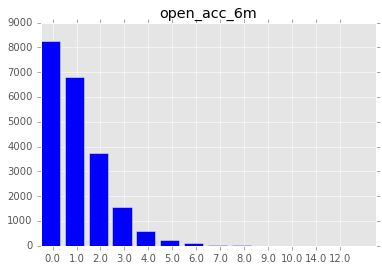

---------------------------
open_il_6m: dtype=float64, 866007 nulls, count vals=35
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        1.00        2.00        4.00       12.00       40.00
BAD         nan         nan         nan         nan         nan         nan         nan


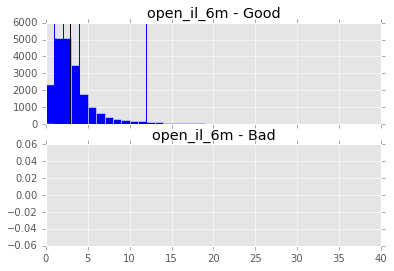

---------------------------
open_il_12m: dtype=float64, 866007 nulls, count vals=12
Total number of distinct values: 12
Total counts
0.0     10806
1.0      6655
2.0      2785
3.0       727
4.0       235
5.0        96
6.0        46
7.0        11
8.0         5
9.0         3
10.0        2
12.0        1
Name: open_il_12m, dtype: int64
Counts for defaulting loans
0.0    NaN
1.0    NaN
2.0    NaN
3.0    NaN
4.0    NaN
5.0    NaN
6.0    NaN
7.0    NaN
8.0    NaN
9.0    NaN
10.0   NaN
12.0   NaN
Name: open_il_12m, dtype: float64


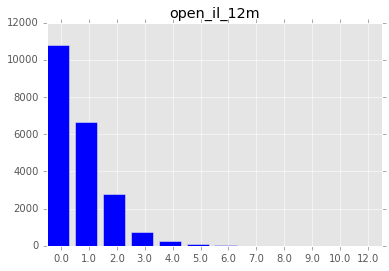

---------------------------
open_il_24m: dtype=float64, 866007 nulls, count vals=17
Total number of distinct values: 17
Total counts
1.0     6436
0.0     5481
2.0     4448
3.0     2468
4.0     1249
5.0      606
6.0      309
7.0      163
8.0       81
9.0       47
10.0      28
11.0      23
12.0      17
13.0       7
14.0       6
15.0       2
19.0       1
Name: open_il_24m, dtype: int64
Counts for defaulting loans
1.0    NaN
0.0    NaN
2.0    NaN
3.0    NaN
4.0    NaN
5.0    NaN
6.0    NaN
7.0    NaN
8.0    NaN
9.0    NaN
10.0   NaN
11.0   NaN
12.0   NaN
13.0   NaN
14.0   NaN
15.0   NaN
19.0   NaN
Name: open_il_24m, dtype: float64


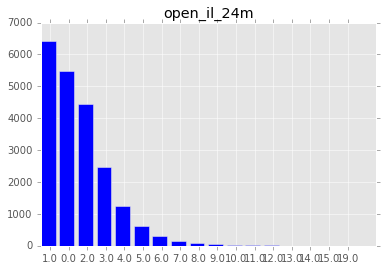

---------------------------
mths_since_rcnt_il: dtype=float64, 866569 nulls, count vals=201
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        1.00        6.00       12.00       23.00      109.00      363.00
BAD         nan         nan         nan         nan         nan         nan         nan


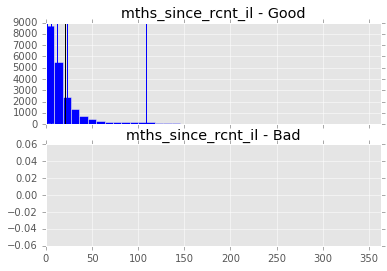

---------------------------
total_bal_il: dtype=float64, 866007 nulls, count vals=17030
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00    10251.50    24684.50    47858.00   151905.75   878459.00
BAD         nan         nan         nan         nan         nan         nan         nan


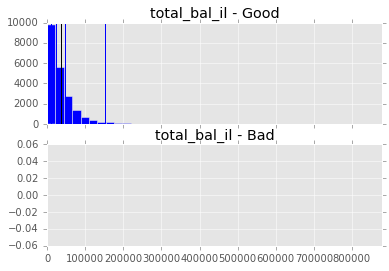

---------------------------
il_util: dtype=float64, 868762 nulls, count vals=1272
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       16.10       58.60       74.90       87.60      108.06      223.30
BAD         nan         nan         nan         nan         nan         nan         nan


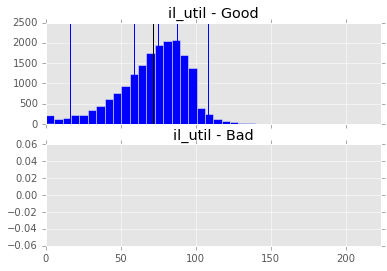

---------------------------
open_rv_12m: dtype=float64, 866007 nulls, count vals=18
Total number of distinct values: 18
Total counts
0.0     7073
1.0     6415
2.0     3955
3.0     2125
4.0      962
5.0      420
6.0      204
7.0      103
8.0       50
10.0      24
9.0       21
12.0       7
11.0       6
14.0       2
15.0       2
19.0       1
16.0       1
22.0       1
Name: open_rv_12m, dtype: int64
Counts for defaulting loans
0.0    NaN
1.0    NaN
2.0    NaN
3.0    NaN
4.0    NaN
5.0    NaN
6.0    NaN
7.0    NaN
8.0    NaN
10.0   NaN
9.0    NaN
12.0   NaN
11.0   NaN
14.0   NaN
15.0   NaN
19.0   NaN
16.0   NaN
22.0   NaN
Name: open_rv_12m, dtype: float64


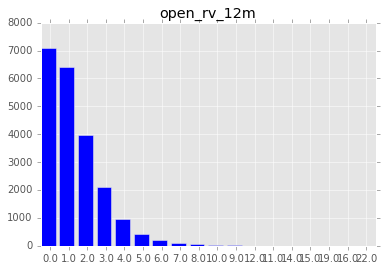

---------------------------
open_rv_24m: dtype=float64, 866007 nulls, count vals=28
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        1.00        2.00        4.00        9.00       43.00
BAD         nan         nan         nan         nan         nan         nan         nan


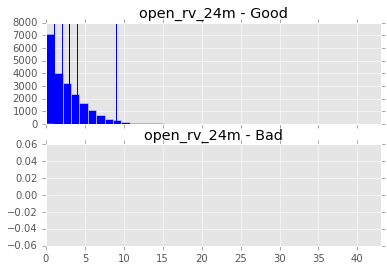

---------------------------
max_bal_bc: dtype=float64, 866007 nulls, count vals=10707
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       71.10     2411.00     4483.00     7771.50    19654.90   127305.00
BAD         nan         nan         nan         nan         nan         nan         nan


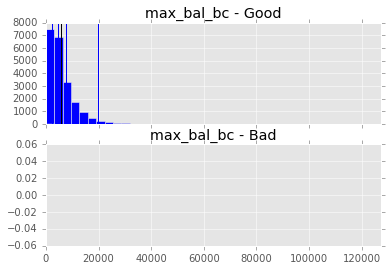

---------------------------
all_util: dtype=float64, 866007 nulls, count vals=1128
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00       18.80       47.70       61.90       75.20       96.00      151.40
BAD         nan         nan         nan         nan         nan         nan         nan


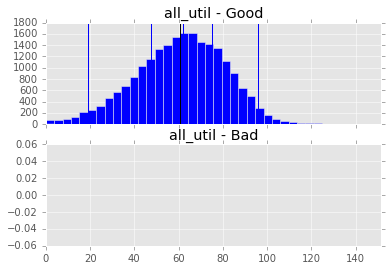

---------------------------
total_rev_hi_lim: dtype=float64, 70276 nulls, count vals=21251
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00     4500.00    14000.00    23900.00    40100.00   108900.00  9999999.00
BAD        0.00     4000.00    12400.00    20500.00    33200.00    81330.00  1998700.00


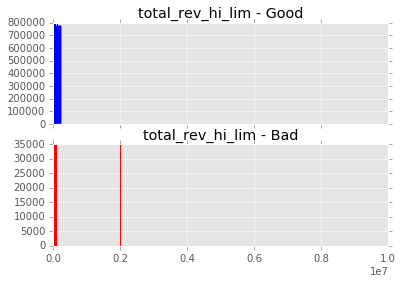

---------------------------
inq_fi: dtype=float64, 866007 nulls, count vals=18
Total number of distinct values: 18
Total counts
0.0     11411
1.0      5009
2.0      2530
3.0      1119
4.0       589
5.0       354
6.0       165
7.0        91
8.0        42
9.0        23
10.0       13
11.0       11
12.0        5
13.0        5
14.0        2
16.0        1
15.0        1
17.0        1
Name: inq_fi, dtype: int64
Counts for defaulting loans
0.0    NaN
1.0    NaN
2.0    NaN
3.0    NaN
4.0    NaN
5.0    NaN
6.0    NaN
7.0    NaN
8.0    NaN
9.0    NaN
10.0   NaN
11.0   NaN
12.0   NaN
13.0   NaN
14.0   NaN
16.0   NaN
15.0   NaN
17.0   NaN
Name: inq_fi, dtype: float64


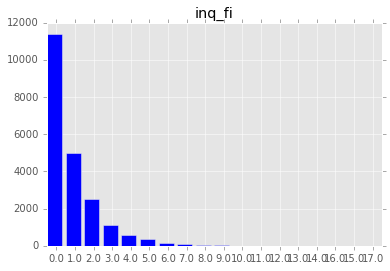

---------------------------
total_cu_tl: dtype=float64, 866007 nulls, count vals=33
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD       0.00        0.00        0.00        0.00        2.00        9.00       35.00
BAD         nan         nan         nan         nan         nan         nan         nan


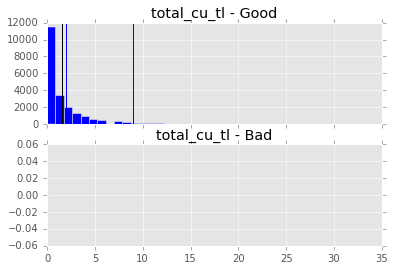

---------------------------
inq_last_12m: dtype=float64, 866007 nulls, count vals=29
            Min        2.5%         25%         50%         75%       97.5%         Max
GOOD      -4.00       -4.00        0.00        2.00        3.00        9.00       32.00
BAD         nan         nan         nan         nan         nan         nan         nan


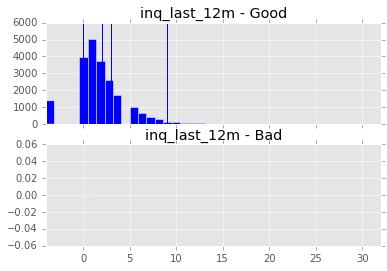

In [40]:
for column in raw_lc_data.columns:
    explore_column(raw_lc_data, column)

TODO on the data exploration:

* Parse dates (done)
* Fix fields that throw exception when plotting (e.g., dates) (done)
* Show min/max as well as quantiles (done)
* Treat dates as special and make subplots per year (or turn histograms into line charts accompanied by boxplots per year)
* Graphically show distribution of categorical values (done)
* Hand-coded ranking/combining of categorical values
* Cutoff should be > 10 (done)
* Color-code by outcome (done)
* Identify missing values
* qq plots against likely inputs
* Discard rows whose outcome is right-censored

In [10]:
vcounts = raw_lc_data['loan_status'].value_counts()
vcounts.index

Index([u'Current', u'Fully Paid', u'Charged Off', u'Late (31-120 days)',
       u'Issued', u'In Grace Period', u'Late (16-30 days)',
       u'Does not meet the credit policy. Status:Fully Paid', u'Default',
       u'Does not meet the credit policy. Status:Charged Off'],
      dtype='object')

In [ ]:
plt.bar(range(len(vcounts)), vcounts)
plt.gca().set_xticks(range(len(vcounts)))
plt.gca().set_xticklabels(vcounts.index)
plt.show()

In [ ]:
print vcounts[0:5].append(pd.Series(vcounts[5:].sum(), index=['Others']))